In [1]:
#-----General------#
import numpy as np
import pandas as pd
import os
import sys
import math
import random
import requests
import json

#-----Plotting-----#
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns
# from pandas_profiling import ProfileReport

#-----Utility-----#
import itertools
import warnings
warnings.filterwarnings("ignore")
import re
import gc
from bs4 import BeautifulSoup as soup
from urllib.request import Request, urlopen
from datetime import date, datetime,timedelta
!pip install fake-useragent
from fake_useragent import UserAgent
ua = UserAgent()

# Previous Data

In [2]:
# Function to convert string date to datetime object
def str_to_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

# Function to convert datetime object to string date
def date_to_str(date_obj):
    return date_obj.strftime('%Y-%m-%d')

# Initialize parameters
base_url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data'
api_key = 'csaPPKuENBgQQVGQTQFgMmUuDTGxdFpr'
headers = {'token': api_key,
           'User-Agent':ua.random,}

# Start and end dates for the entire data fetching period
start_date = str_to_date('2020-08-15')
end_date = str_to_date('2023-11-01')
2
# Adjust this depending on how much data you expect each day
days_per_request = 50

# DataFrame to hold all results
all_data_1 = pd.DataFrame()

while start_date < end_date:
    # Update end date for the request
    request_end_date = min(start_date + timedelta(days=days_per_request), end_date)

    # Set up parameters for the request
    params = {
        'datasetid': 'GHCND',
        'locationid': 'CITY:US360019',
        'stationid':'GHCND:USW00094728',
        'startdate': date_to_str(start_date),
        'enddate': date_to_str(request_end_date),
        'units': 'metric',
        'limit': 1000
    }

    # Make the request
    response = requests.get(base_url, headers=headers, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()

        # Convert this part of the results to a DataFrame and append
        part_data = pd.json_normalize(data['results'])
        all_data_1 = pd.concat([all_data_1, part_data], ignore_index=True)

        # Update the start date for the next request
        start_date = request_end_date + timedelta(days=1)
    else:
        print(f"Error: {response.status_code} - {response.text}")
        break

Error: 503 - <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>503 Service Unavailable</title>
</head><body>
<h1>Service Unavailable</h1>
<p>The server is temporarily unable to service your
request due to maintenance downtime or capacity
problems. Please try again later.</p>
<p>Additionally, a 503 Service Unavailable
error was encountered while trying to use an ErrorDocument to handle the request.</p>
</body></html>



# Make previous data as dataframe

In [3]:
df_prev = all_data_1.copy()

df_prev = df_prev.drop(columns=['attributes','station'])
df_prev = df_prev.pivot(index='date', columns='datatype', values='value')
df_prev = df_prev.drop(columns=['TSUN'])

# Check the consistency

In [4]:
# Define the start and end dates
start_date = datetime(2020, 8, 15)
end_date = datetime(2023, 11, 1)

# Calculate the number of days between the two dates
number_of_days = (end_date - start_date).days
print(number_of_days)

print(df_prev.shape)

1173
(408, 23)


# Get today's data

In [5]:
# Start and end dates for the entire data fetching period
start_date = str_to_date('2023-11-02')
end_date = datetime.now()
2
# Adjust this depending on how much data you expect each day
days_per_request = 50

# DataFrame to hold all results
all_data = pd.DataFrame()

while start_date < end_date:
    # Update end date for the request
    request_end_date = min(start_date + timedelta(days=days_per_request), end_date)

    # Set up parameters for the request
    params = {
        'datasetid': 'GHCND',
        'locationid': 'CITY:US360019',
        'stationid':'GHCND:USW00094728',
        'startdate': date_to_str(start_date),
        'enddate': date_to_str(request_end_date),
        'units': 'metric',
        'limit': 1000
    }

    # Make the request
    response = requests.get(base_url, headers=headers, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()

        # Convert this part of the results to a DataFrame and append
        part_data = pd.json_normalize(data['results'])
        all_data = pd.concat([all_data, part_data], ignore_index=True)

        # Update the start date for the next request
        start_date = request_end_date + timedelta(days=1)
    else:
        print(f"Error: {response.status_code} - {response.text}")
        break

# Make today's data as df

In [6]:
df_today = all_data.copy()
df_today = df_today.drop(columns=['attributes','station'])
df_today = df_today.pivot(index='date', columns='datatype', values='value')
print(df_today.shape)
from datetime import datetime

# Define the start and end dates
start_date = datetime(2023, 11, 1)
end_date = datetime.now()

# Calculate the number of days between the two dates
number_of_days = (end_date - start_date).days
print(number_of_days)
# df_today = df_today.drop(columns=['PGTM'])

(35, 12)
39


# Check the columms from two dataset(for self use)

In [7]:

# Get the columns of each dataset
columns_df1 = set(df_prev.columns)
columns_df2 = set(df_today.columns)

# Compare columns
if columns_df1 == columns_df2:
    print("Both datasets have the same columns.")
else:
    print("Datasets do not have the same columns.")

    # To see which columns are different
    only_in_df1 = columns_df1 - columns_df2
    only_in_df2 = columns_df2 - columns_df1

    if only_in_df1:
        print("Columns only in the first dataset:", only_in_df1)
    if only_in_df2:
        print("Columns only in the second dataset:", only_in_df2)


Datasets do not have the same columns.
Columns only in the first dataset: {'ASLP', 'WT06', 'ASTP', 'RHMX', 'WT02', 'RHMN', 'AWBT', 'WT03', 'ADPT', 'WT04', 'RHAV'}


# Try to combine them together

In [8]:
column_name = 'PGTM'  # Replace 'col' with your actual column name

# Check if the column exists in the DataFrame and drop it if it does
if column_name in df_today.columns:
    df_today = df_today.drop(columns=[column_name])
df_combine = pd.concat([df_prev,df_today],axis=0)
df_combine.index = pd.to_datetime(df_combine.index)

In [9]:
df_combine.shape

(443, 23)

In [10]:
df_combine.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 443 entries, 2020-08-15 to 2023-12-06
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ADPT    404 non-null    float64
 1   ASLP    404 non-null    float64
 2   ASTP    404 non-null    float64
 3   AWBT    404 non-null    float64
 4   AWND    432 non-null    float64
 5   PRCP    443 non-null    float64
 6   RHAV    404 non-null    float64
 7   RHMN    404 non-null    float64
 8   RHMX    404 non-null    float64
 9   SNOW    443 non-null    float64
 10  SNWD    443 non-null    float64
 11  TMAX    443 non-null    float64
 12  TMIN    443 non-null    float64
 13  WDF2    433 non-null    float64
 14  WDF5    426 non-null    float64
 15  WSF2    433 non-null    float64
 16  WSF5    426 non-null    float64
 17  WT01    175 non-null    float64
 18  WT02    15 non-null     float64
 19  WT03    32 non-null     float64
 20  WT04    5 non-null      float64
 21  WT06    3 non-null  

#  handle multiple columns with missing data and fill them with the average values from the corresponding day in previous years

In [11]:
average_values = df_combine.groupby([df_combine.index.month, df_combine.index.day]).mean()

def impute_missing(row, avg_values):
    for col in df_combine.columns:
        if pd.isna(row[col]):
            month_day = (row.name.month, row.name.day)
            row[col] = avg_values.loc[month_day, col]
    return row
df_combine = df_combine.apply(impute_missing, axis=1, args=(average_values,))

df_combine.fillna(0, inplace=True)
df_combine.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 443 entries, 2020-08-15 to 2023-12-06
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ADPT    443 non-null    float64
 1   ASLP    443 non-null    float64
 2   ASTP    443 non-null    float64
 3   AWBT    443 non-null    float64
 4   AWND    443 non-null    float64
 5   PRCP    443 non-null    float64
 6   RHAV    443 non-null    float64
 7   RHMN    443 non-null    float64
 8   RHMX    443 non-null    float64
 9   SNOW    443 non-null    float64
 10  SNWD    443 non-null    float64
 11  TMAX    443 non-null    float64
 12  TMIN    443 non-null    float64
 13  WDF2    443 non-null    float64
 14  WDF5    443 non-null    float64
 15  WSF2    443 non-null    float64
 16  WSF5    443 non-null    float64
 17  WT01    443 non-null    float64
 18  WT02    443 non-null    float64
 19  WT03    443 non-null    float64
 20  WT04    443 non-null    float64
 21  WT06    443 non-null

# Feature enginnering (using the regular method without)

In [12]:
df_combine['TAVG'] = (df_combine['TMAX'].astype(float)+df_combine['TMIN'].astype(float))/2
columns_to_shift = ['TAVG','TMAX', 'TMIN', 'PRCP', 'SNOW', 'AWND', 'RHAV', 'RHMN', 'RHMX', 'ADPT', 'ASLP', 'ASTP']

for col in columns_to_shift:
    for i in range(1, 4):  # Shift 1, 2, and 3 steps
        df_combine[f'{col}_{i}'] = df_combine[col].shift(i)


df_combine = df_combine.dropna()
scaled_df = df_combine
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 440 entries, 2020-08-18 to 2023-12-06
Data columns (total 60 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ADPT    440 non-null    float64
 1   ASLP    440 non-null    float64
 2   ASTP    440 non-null    float64
 3   AWBT    440 non-null    float64
 4   AWND    440 non-null    float64
 5   PRCP    440 non-null    float64
 6   RHAV    440 non-null    float64
 7   RHMN    440 non-null    float64
 8   RHMX    440 non-null    float64
 9   SNOW    440 non-null    float64
 10  SNWD    440 non-null    float64
 11  TMAX    440 non-null    float64
 12  TMIN    440 non-null    float64
 13  WDF2    440 non-null    float64
 14  WDF5    440 non-null    float64
 15  WSF2    440 non-null    float64
 16  WSF5    440 non-null    float64
 17  WT01    440 non-null    float64
 18  WT02    440 non-null    float64
 19  WT03    440 non-null    float64
 20  WT04    440 non-null    float64
 21  WT06    440 non-null

# Model Training

In [13]:
import tensorflow as tf
from sklearn.model_selection import train_test_split,GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.regularizers import l2

Epoch 1/200
9/9 [==============================] - 9s 55ms/step - loss: 291.9035 - mse: 279.5101 - val_loss: 267.9105 - val_mse: 255.5581
Epoch 2/200
9/9 [==============================] - 0s 16ms/step - loss: 242.6345 - mse: 230.2837 - val_loss: 225.3218 - val_mse: 212.9559
Epoch 3/200
9/9 [==============================] - 0s 26ms/step - loss: 196.8122 - mse: 184.4126 - val_loss: 184.0032 - val_mse: 171.5435
Epoch 4/200
9/9 [==============================] - 0s 26ms/step - loss: 155.5025 - mse: 142.9759 - val_loss: 144.0264 - val_mse: 131.4016
Epoch 5/200
9/9 [==============================] - 0s 28ms/step - loss: 116.2232 - mse: 103.5156 - val_loss: 111.0595 - val_mse: 98.2352
Epoch 6/200
9/9 [==============================] - 0s 12ms/step - loss: 87.0272 - mse: 74.1135 - val_loss: 86.9397 - val_mse: 73.9112
Epoch 7/200
9/9 [==============================] - 0s 19ms/step - loss: 67.3251 - mse: 54.2179 - val_loss: 69.3092 - val_mse: 56.1111
Epoch 8/200
9/9 [==========================

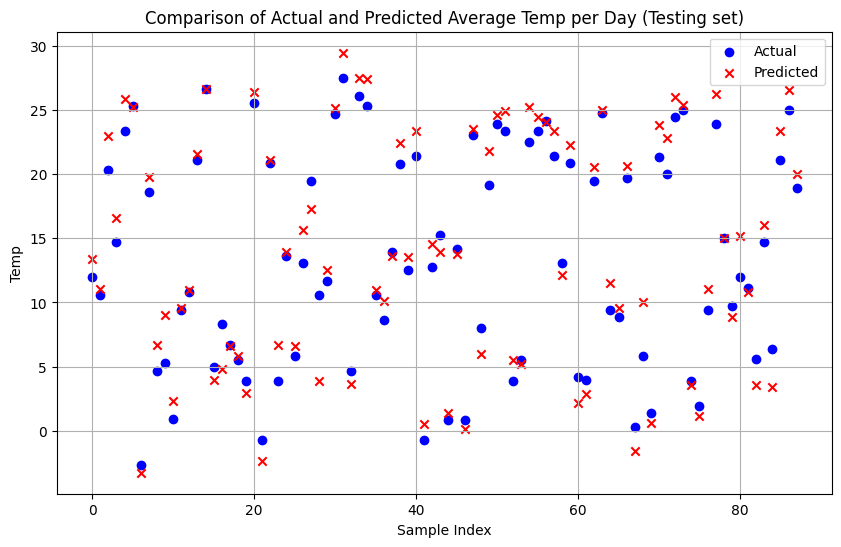

In [14]:
df_train = scaled_df.drop(columns=['TAVG','TMIN','TMAX'], axis=1)
model_features = df_train
target = scaled_df['TAVG']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(model_features, target, test_size=0.2, random_state=42)

scaler_x = StandardScaler()
scale = scaler_x.fit_transform(X_train)
X_train = pd.DataFrame(scale, columns=X_train.columns,index=X_train.index)


scaler = StandardScaler()
scale = scaler.fit_transform(X_test)
X_test = pd.DataFrame(scale, columns=X_test.columns,index=X_test.index)
l2_lambda = 0.1

model = Sequential([
    Dense(64, activation='elu', input_shape=(X_train.shape[1],),kernel_regularizer=l2(l2_lambda)),
    Dense(64, activation='elu',kernel_regularizer=l2(l2_lambda)),
    Dense(1)  # Output layer with one neuron and no activation for regression
])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

optimizer=Adam(learning_rate = 0.001)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2,callbacks=[early_stopping])


loss = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
predictions = model.predict(X_test)
print(f"Predictions: {predictions[:,0]}")
print(f"Actual: {y_test}")
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

import matplotlib.pyplot as plt
# Plotting y_test vs y_pred_rf to compare the actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.reset_index().index, y_test.values, label='Actual', color='blue', marker='o')
plt.scatter(y_test.reset_index().index, predictions, label='Predicted', color='red', marker='x')

plt.title('Comparison of Actual and Predicted Average Temp per Day (Testing set)')
plt.xlabel('Sample Index')
plt.ylabel('Temp')
plt.legend()
plt.grid(True)
plt.show()



# Plot the model

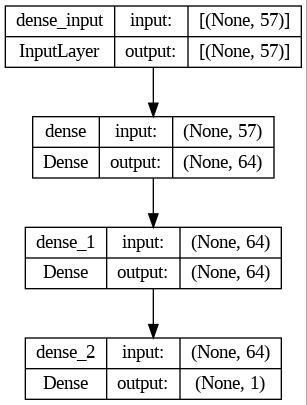

In [15]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.jpg', show_shapes=True, show_layer_names=True)

# data viz

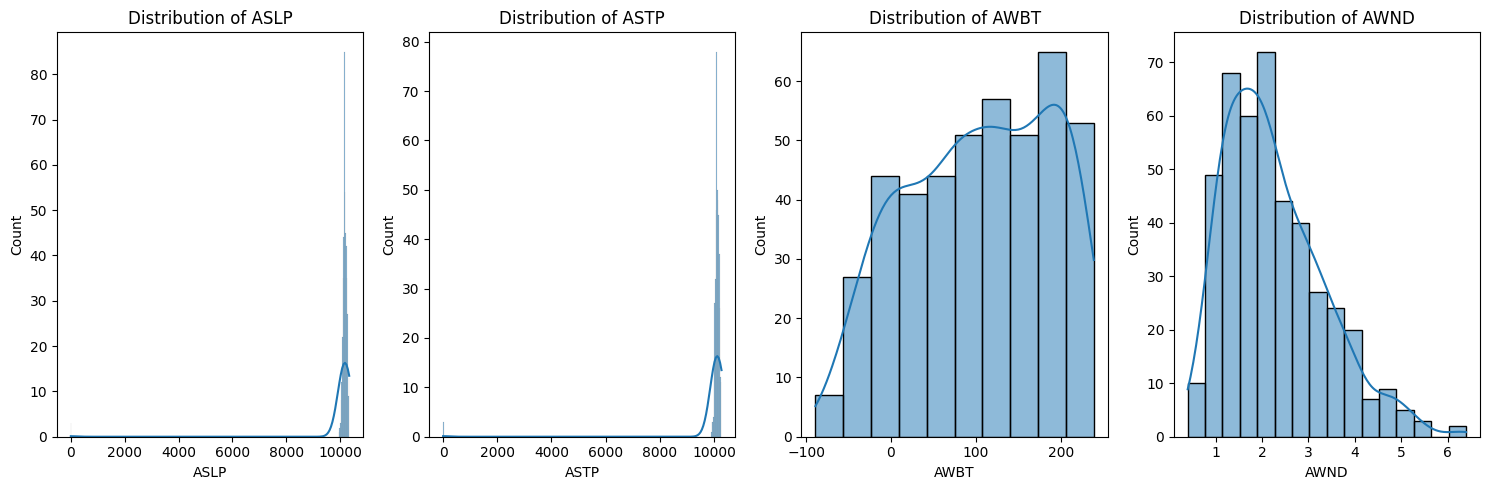

(datatype
 ADPT      0
 ASLP      0
 ASTP      0
 AWBT      0
 AWND      0
 PRCP      0
 RHAV      0
 RHMN      0
 RHMX      0
 SNOW      0
 SNWD      0
 TMAX      0
 TMIN      0
 WDF2      0
 WDF5      0
 WSF2      0
 WSF5      0
 WT01      0
 WT02      0
 WT03      0
 WT04      0
 WT06      0
 WT08      0
 TAVG      0
 TAVG_1    0
 dtype: int64,
 datatype        ADPT          ASLP          ASTP        AWBT        AWND
 count     440.000000    440.000000    440.000000  440.000000  440.000000
 mean       63.620455  10102.520455  10052.993182  103.868182    2.256136
 std       102.371934    840.788262    836.690853   84.630112    1.073732
 min      -194.000000      0.000000      0.000000  -89.000000    0.400000
 25%       -17.000000  10125.000000  10077.250000   37.500000    1.400000
 50%        67.000000  10166.000000  10119.000000  111.000000    2.100000
 75%       156.000000  10217.000000  10169.000000  178.000000    2.900000
 max       228.000000  10332.000000  10281.000000  239.000

In [16]:
# Plot purpose
df_combine = df_combine.drop(df_combine.columns[25:],axis=1)
# Check for missing values
missing_values = df_combine.isnull().sum()

# Summary statistics for numerical features
summary_stats = df_combine.describe()

# Correlation matrix
corr_matrix = df_combine.corr()

# Plotting the distribution of the first few numerical features
plt.figure(figsize=(15, 5))
for i, column in enumerate(df_combine.columns[1:5], 1):  # Skip the date column
    plt.subplot(1, 4, i)
    sns.histplot(df_combine[column], kde=True)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

missing_values, summary_stats.iloc[:, :5], corr_matrix.iloc[:5, :5]  # Displaying a subset for clarity


# Check the correlation

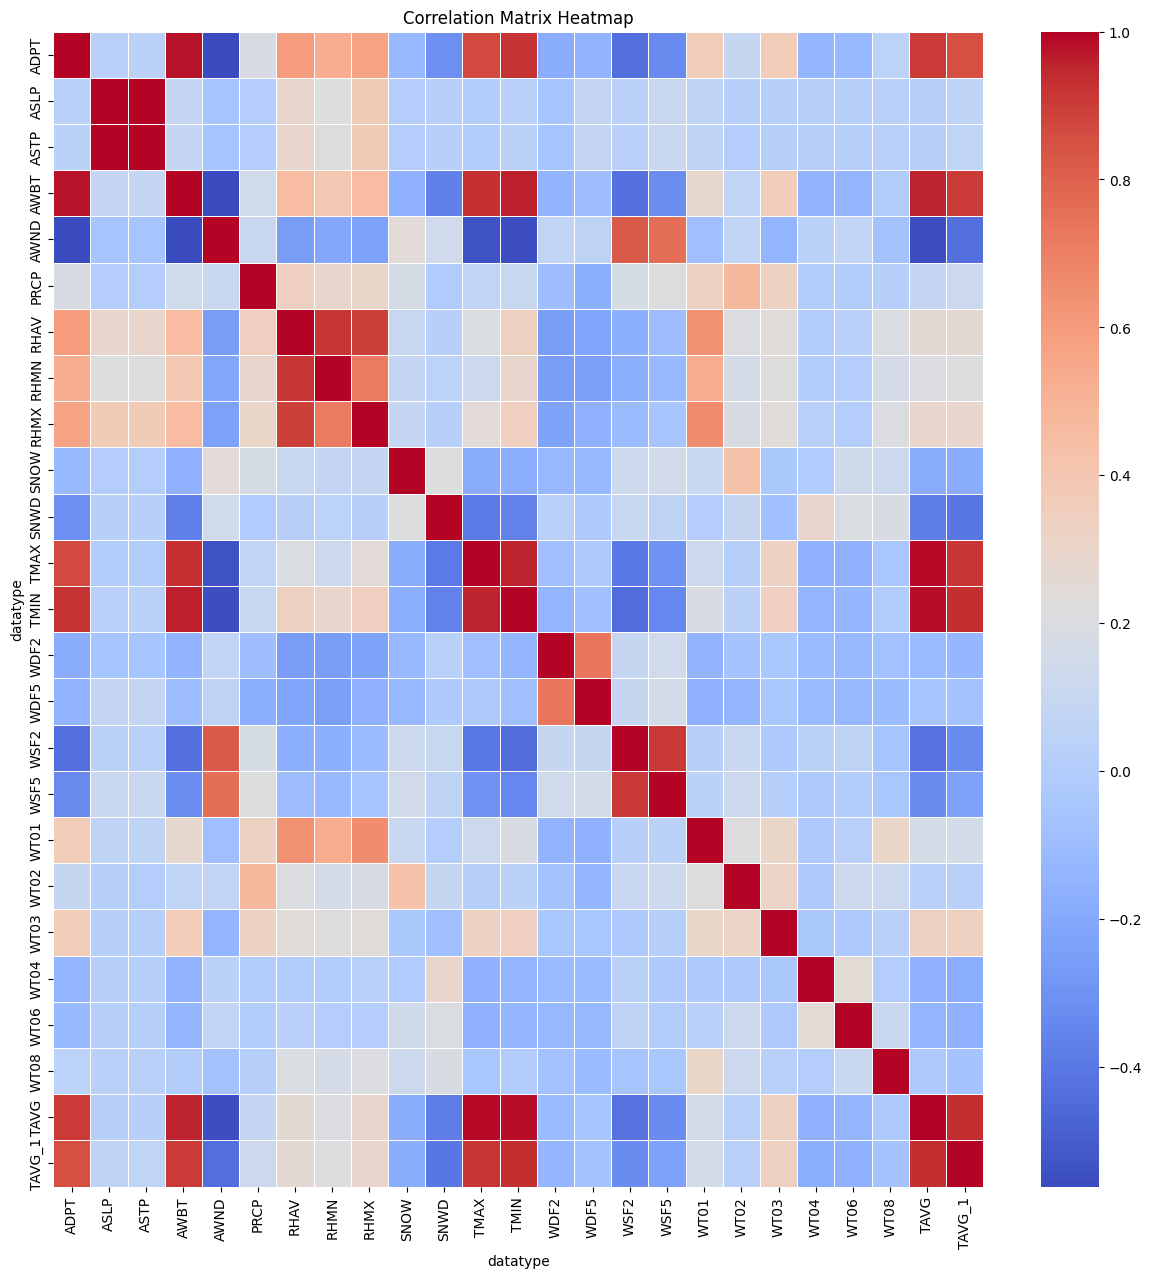

In [17]:
# Plotting the correlation matrix heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


# Detect highly correlated

In [18]:
# Identifying highly correlated pairs with a threshold of 0.9
correlation_threshold = 0.9
highly_correlated_pairs = []

# Iterate over the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            col_pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            highly_correlated_pairs.append(col_pair)

# Converting to a DataFrame for better readability
highly_correlated_pairs_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
highly_correlated_pairs_df.sort_values(by='Correlation', ascending=False)


,Feature 1,Feature 2,Correlation
0,ASTP,ASLP,0.999972
10,TAVG,TMAX,0.989460
11,TAVG,TMIN,0.987225
1,AWBT,ADPT,0.978424
5,TMIN,AWBT,0.961555
9,TAVG,AWBT,0.956365
6,TMIN,TMAX,0.953747
14,TAVG_1,TMIN,0.937776
15,TAVG_1,TAVG,0.937266
3,TMAX,AWBT,0.930464


# Create future data features

In [19]:
from pandas.tseries.offsets import DateOffset

# Get the last date in the dataset
last_date = scaled_df.index[-80]

# Calculate the date 30 days after today
today = pd.Timestamp.now().normalize()
thirty_days_after_today = today + DateOffset(days=30)

# Create a date range from the last date in the dataset to 30 days after today
extended_dates = pd.date_range(start=last_date + DateOffset(days=1), end=thirty_days_after_today)

# Create a dataframe with these new dates and NaN values for the columns
extended_data = pd.DataFrame(index=extended_dates, columns=scaled_df.columns)

# # Remove the target feature
# extended_data = extended_data.drop(columns=['TAVG'])

# Display the last few rows to verify the extension
extended_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 879 entries, 2021-08-14 to 2024-01-09
Freq: D
Data columns (total 60 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ADPT    0 non-null      object
 1   ASLP    0 non-null      object
 2   ASTP    0 non-null      object
 3   AWBT    0 non-null      object
 4   AWND    0 non-null      object
 5   PRCP    0 non-null      object
 6   RHAV    0 non-null      object
 7   RHMN    0 non-null      object
 8   RHMX    0 non-null      object
 9   SNOW    0 non-null      object
 10  SNWD    0 non-null      object
 11  TMAX    0 non-null      object
 12  TMIN    0 non-null      object
 13  WDF2    0 non-null      object
 14  WDF5    0 non-null      object
 15  WSF2    0 non-null      object
 16  WSF5    0 non-null      object
 17  WT01    0 non-null      object
 18  WT02    0 non-null      object
 19  WT03    0 non-null      object
 20  WT04    0 non-null      object
 21  WT06    0 non-null      object
 22 

# add features int terms of the previous data

In [20]:
for date in extended_data.index:
    if date in scaled_df.index:
        extended_data.loc[date] = scaled_df.loc[date]
def impute_missing_pred(row, avg_values):
    for col in scaled_df.columns:
        if pd.isna(row[col]):
            month_day = (row.name.month, row.name.day)
            row[col] = avg_values.loc[month_day, col]
    return row
average_values_pred = scaled_df.groupby([scaled_df.index.month, scaled_df.index.day]).mean()

extended_data = extended_data.apply(impute_missing_pred, axis=1, args=(average_values_pred,))
scaled_df_pred = extended_data

In [21]:
scaled_df_pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 879 entries, 2021-08-14 to 2024-01-09
Freq: D
Data columns (total 60 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ADPT    879 non-null    float64
 1   ASLP    879 non-null    float64
 2   ASTP    879 non-null    float64
 3   AWBT    879 non-null    float64
 4   AWND    879 non-null    float64
 5   PRCP    879 non-null    float64
 6   RHAV    879 non-null    float64
 7   RHMN    879 non-null    float64
 8   RHMX    879 non-null    float64
 9   SNOW    879 non-null    float64
 10  SNWD    879 non-null    float64
 11  TMAX    879 non-null    float64
 12  TMIN    879 non-null    float64
 13  WDF2    879 non-null    float64
 14  WDF5    879 non-null    float64
 15  WSF2    879 non-null    float64
 16  WSF5    879 non-null    float64
 17  WT01    879 non-null    float64
 18  WT02    879 non-null    float64
 19  WT03    879 non-null    float64
 20  WT04    879 non-null    float64
 21  WT06    879 

# Generate the prediction

In [22]:
scaled_df_pred = scaled_df_pred.drop(columns=['TAVG','TMIN','TMAX'], axis=1)
mock_data_normalized = scaler.transform(scaled_df_pred)
predictions_predictions = model.predict(mock_data_normalized)

28/28 [==============================] - 0s 3ms/step


# Final Graph

In [23]:
predictions_predictions_flattened = [item for sublist in predictions_predictions for item in sublist]

# Assuming 'df_combine' and 'scaled_df_pred' are your DataFrames and 'var4_flattened' is your prediction data

fig_1 = go.Figure()

# Adding line for df1
fig_1.add_trace(go.Scatter(x=df_combine.index, y=df_combine['TAVG'], mode='lines', name='Actual'))

# Adding line for df2
fig_1.add_trace(go.Scatter(x=scaled_df_pred.index, y=predictions_predictions_flattened, mode='lines', name='Prediction'))

# Updating layout with range slider
fig_1.update_layout(
    xaxis_title='Date',
    yaxis_title='Value',
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type='date'  # Assuming x-axis is datetime, change if otherwise
    )
)

# Show the plot
fig_1.show()


# Dash board

In [24]:
!pip install dash
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 42.4 MB/s eta 0:00:00


# Generate Heatmp to dash

In [25]:
def generate_heatmap(selected_features):

    filtered_data = df_combine[selected_features]
    correlation_matrix = filtered_data.corr()
    fig = px.imshow(correlation_matrix,
                    labels=dict(x="Features_1", y="Features_2", color="Correlation"),
                    x=correlation_matrix.columns,
                    y=correlation_matrix.columns,
                    color_continuous_scale='pinkyl')
    fig.update_layout(title='Feature Correlation Heatmap', title_x=0.5)
    return fig


# Generate model digram

In [26]:
import base64

def encode_image(image_file):
    with open(image_file, 'rb') as file:
        return base64.b64encode(file.read()).decode('ascii')

# Generate Pred graph

In [27]:
import plotly.graph_objs as go

predictions_flattened = [item for sublist in predictions for item in sublist]

# Assuming y_test and predictions are your data
scatter_plot = go.Figure()

# Actual Values
scatter_plot.add_trace(go.Scatter(
    x=y_test.reset_index().index,
    y=y_test.values,
    mode='markers',
    name='Actual',
    marker=dict(color='blue')
))

# Predicted Values
scatter_plot.add_trace(go.Scatter(
    x=y_test.reset_index().index,
    y=predictions_flattened,
    mode='markers',
    name='Predicted',
    marker=dict(color='red', symbol='x')
))

# Updating layout
scatter_plot.update_layout(
    # title='Comparison of Actual and Predicted Average Temp per Day',title_x=0.5,
    xaxis_title='Sample Index',
    yaxis_title='Temp',
    legend_title='Legend',
    template='plotly_white'
)


# Main layout

In [28]:
from dash import Dash, html, dcc

app = Dash(__name__)

app.layout = html.Div([
    html.H1('DATA 602 Final Project Weather Forcasting in Central Park', style={'textAlign': 'center'}),

    # Dropdown and line chart for time series
    dcc.Dropdown(
        id='column-dropdown',
        options=[{'label': col, 'value': col} for col in df_combine.columns],
        value='TAVG'
    ),
    dcc.Graph(id='line-chart'),

    # Flex container for heatmap and model diagram
    html.Div([
        # Heatmap
        html.Div([
            html.H2('Select Features for Correlation Heatmap'),
            dcc.Dropdown(
                id='feature-select-dropdown',
                options=[{'label': col, 'value': col} for col in df_combine.columns],
                value=df_combine.columns.tolist()[:5],  # Default selected values
                multi=True
            ),
            dcc.Graph(id='feature-correlation-heatmap')
        ], style={'flex': '1'}),

        # Model Diagram
        html.Div([
            html.H2('Simple model diagram'),
            html.Img(src='data:image/png;base64,{}'.format(encode_image('model_plot.jpg')),
                     style={})
        ], style={'flex': '1'})
    ], style={'display': 'flex', 'flex-direction': 'row', 'align-items': 'stretch', 'textAlign': 'center', 'flex-flow': 'space-evenly', 'margin-bottom': '20px'}),  # Added margin-bottom here

    # predicted map
    html.Div([
        html.H2('Comparison of Actual and Predicted Average Temp per Day',style={'textAlign': 'center'}),
        dcc.Graph(figure=scatter_plot)
    ], style={'flex': '1', 'flex-flow': 'space-evenly'}),
    html.Div([
        html.H2('Weather forcasting for Next few days',style={'textAlign': 'center'}),
        dcc.Graph(figure=fig_1)
    ], style={'flex': '1', 'flex-flow': 'space-evenly'})

], style={'flex': '1', 'flex-flow': 'space-evenly'})


# add callback

In [29]:
@app.callback(
    Output('line-chart', 'figure'),
    [Input('column-dropdown', 'value')]
)
def update_chart(selected_column):
    fig = px.line(df_combine, x=df_combine.index, y=['TAVG', selected_column])
    fig.update_layout(title='Comparison of TAVG and Features Column', title_x=0.5)

    return fig
# callback for heatmap
@app.callback(
    Output('feature-correlation-heatmap', 'figure'),
    [Input('feature-select-dropdown', 'value')]
)
def update_heatmap(selected_features):
    return generate_heatmap(selected_features)



In [30]:
if __name__ == '__main__':
    app.run_server(debug=True,host="127.0.0.1", port=8050)


<IPython.core.display.Javascript object>